## An example Stone Soup notebook demonstrating inference using an extended Kalman filter on an orbital scenario 

This notebook is somewhat analogous to the tutorial notebook on the EKF. The difference is that, rather 
than a nearly constant velocity model, this notebook simulates a nearly-Keplerian orbit. A 'sensor' which is 
capable of measuring the 6d Cartesian position/velocity vector with additive Gaussian noise is imagined. Inference
is then done using an extended Kalman filter. The output is plotted. No metrics are generated.

Start with some necessary imports

In [1]:
%matplotlib notebook

# Import libraries
import numpy as np
import scipy as sp
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

Set the initial time (chosen for no particular reason) and time increment 

In [2]:
start_time = datetime(2011, 11, 12, 13, 45, 31)  # No reason

deltat = timedelta(seconds=60) # Propagate in discrete time at minute intervals

#### Ground truth 

Initialise a "ground-truth" state vector. It's value isn't tremendously important, just note that it's 
defined in 6-d Cartesian (ECI) coordinates [km, km/s] 

In [3]:
from stonesoup.types.orbitalstate import OrbitalState
ini_cart = np.array([[7000], [-12124], [0], [2.6679], [4.621], [0]])
gtstate = OrbitalState(ini_cart, coordinates="Cartesian", timestamp=start_time)
gtstate.grav_parameter = 398600 # Because we're in km, rather than m

Initialise a transition model which will serve to generate the ground truth

In [4]:
from stonesoup.models.transition.orbital.orbit import CartesianTransitionModel
propagator = CartesianTransitionModel()
propagator.noise = np.diag([1e-5, 1e-5, 1e-5, 1e-8, 1e-8, 1e-8]) # per second

We'll assume that we can measure the 6-d state directly subject to some additive Gaussian noise. Define the 
matrix which will generate this noise.

In [5]:
sensor_noise = np.diag([100, 100, 100, 1, 1, 1])

Initialise arrays which we will use for plotting ground truth and measurements

In [6]:
all_xy = np.array([gtstate.cartesian_state_vector[0], gtstate.cartesian_state_vector[1]])
sens_xy = np.empty([2,0])

Run a loop to generate the ground truth state and sensed state. Store these for later. The simulation runs in 
minute increments for a total of 6 hours. 

In [7]:
from scipy.stats import multivariate_normal # To generate noise
gtstates = [gtstate]
sensed_states = []
time = start_time

while time < start_time + timedelta(minutes=360):
    # Do the propagation
    gtstatevector = propagator.rvs(1, gtstates[-1], deltat) 
    # Increment the time
    time = time + deltat 
    # Add new state to states to date
    gtstates.append(OrbitalState(gtstatevector, timestamp=time, grav_parameter=398600))
    # Simulate a measurement
    sensed_state_vector = gtstates[-1].state_vector + \
        np.array([multivariate_normal.rvs(mean=np.zeros(6), cov=sensor_noise)]).T
    # Add this measurement to the collection of measurements
    sensed_state = OrbitalState(sensed_state_vector, timestamp=time, grav_parameter=398600)
    sensed_state.measurement_model = None # required by Kalman filtering routines
    sensed_states.append(sensed_state)
    # Put the state vector x,y Cartesian coordinates into vectors for plotting
    all_xy = np.append(all_xy, np.array([gtstatevector[0], gtstatevector[1]]), axis=1)
    sens_xy = np.append(sens_xy, 
                        np.array([sensed_state_vector[0], 
                                  sensed_state_vector[1]]), axis=1)

Plot a simple Earth radius by way of a parametric equation

In [8]:
th = np.arange(0, 2*np.pi, np.pi/100)
xx = 6371*np.cos(th)
yy = 6371*np.sin(th)

And do the plotting. Ground truth is red with the markers denoting the times at which observations are made, 
sensor measurements are shown in green. 

<IPython.core.display.Javascript object>


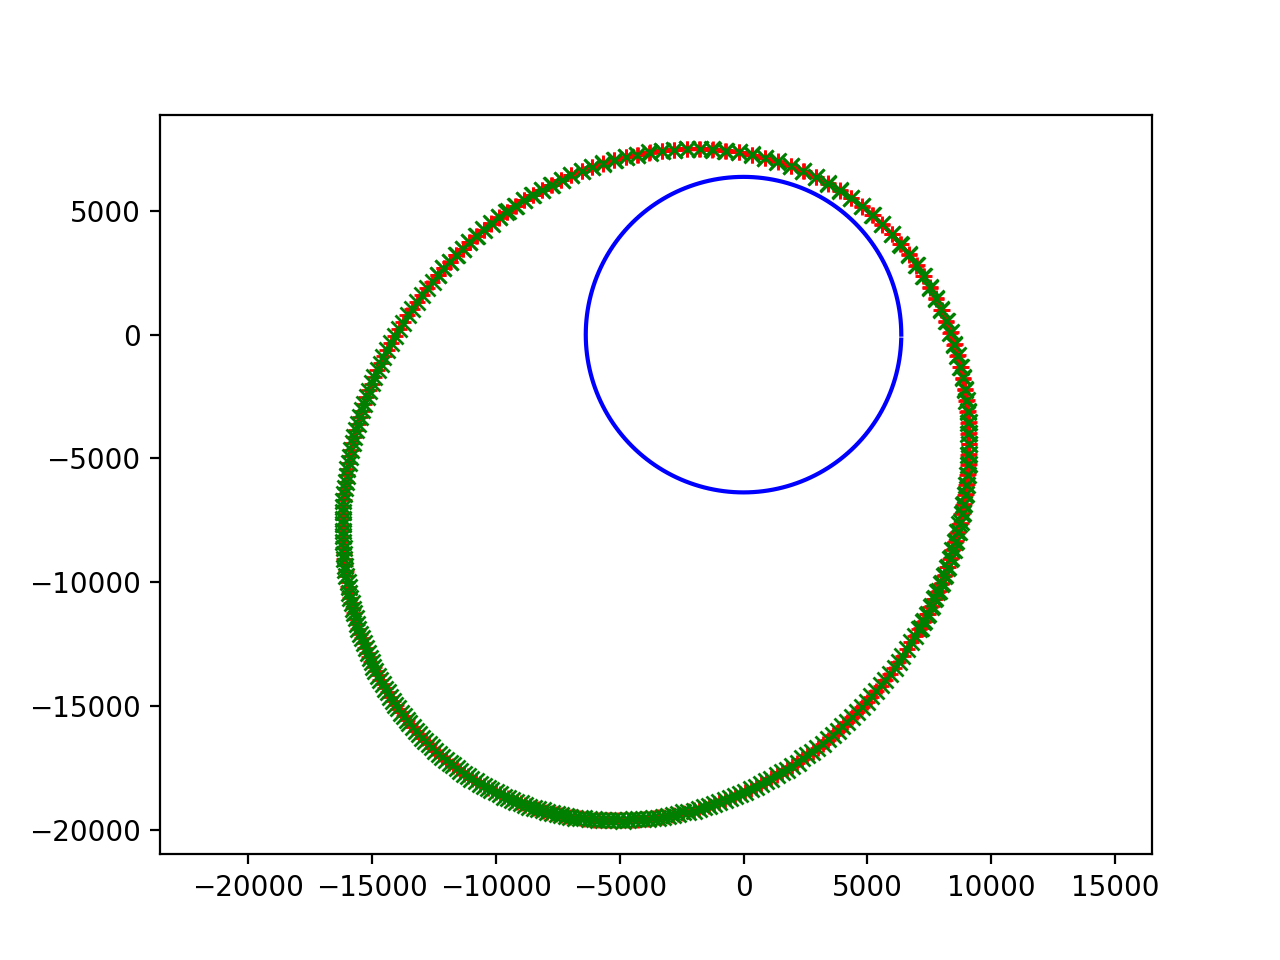

In [9]:
plt.plot(xx,yy,color="blue") 
plt.plot(all_xy[:][0], all_xy[:][1], color="red", marker="+") # Just about
plt.plot(sens_xy[:][0], sens_xy[:][1],'x', color="green")
plt.gcf().gca().axis('equal')
plt.show()

##### Prepare the Stone Soup EKF components. 

Reset the initial time and increment 

In [10]:
time = start_time  

Create a prior state vector - one quite close to the initial value. Remember that the ground truth was 
\[\[7000 km\], [-12124 km], [0 km], [2.6679 km/s], [4.621 km/s], [0 km/s]]

In [11]:
ini_cart = np.array([[7020], [-12134], [0], [2.667], [4.63], [0]])
prior = OrbitalState(ini_cart, coordinates="Cartesian", timestamp=time)
prior.grav_parameter = 398600 # Because we're in km, rather than m

In order to make the Kalman components work we need to parameterise this state as MVN-distributed. 
So give it a covariance matrix. Initialise with some (moderately sensible but large) uncertainty

In [12]:
prior.covar = np.diag([100, 100, 100, 10, 10, 10])

We use the Cartesian propagator as our transition model but give it a larger process noise

In [13]:
transition_model = propagator
transition_model.noise = np.diag([10, 10, 10, 1, 1, 1]) # per sec

Use a linear Gaussian measurement model that can 'see' the full state

In [14]:
from stonesoup.models.measurement.linear import LinearGaussian
measurement_model = LinearGaussian(
    6, # Number of state dimensions (position and velocity in 2D)
    (0,1,2,3,4,5), # Mapping measurement vector index to state index
    np.diag([100, 100, 100, 1, 1, 1])
    )

The predictor and updater

In [15]:
from stonesoup.predictor.kalman import ExtendedKalmanPredictor
predictor = ExtendedKalmanPredictor(transition_model)

from stonesoup.updater.kalman import ExtendedKalmanUpdater
updater = ExtendedKalmanUpdater(measurement_model)

Cycle through the stored sensed states, operate the predict/update cycle and add to track object

In [16]:
from stonesoup.types.hypothesis import SingleHypothesis
from stonesoup.types.track import Track

track = Track()
for sensed_state in sensed_states:
    prediction_G = predictor.predict(prior, timestamp=sensed_state.timestamp)   
    prediction = OrbitalState(prediction_G.state_vector, 
                              timestamp=sensed_state.timestamp, grav_parameter=prior.grav_parameter)
    prediction.covar = prediction_G.covar
    hypothesis = SingleHypothesis(prediction, sensed_state) # Used to group a prediction and measurement together
    post = updater.update(hypothesis) # This is a gaussian state
    posteriorstate = OrbitalState(post.state_vector, timestamp=sensed_state.timestamp, 
                                  grav_parameter=prediction.grav_parameter)
    posteriorstate.covar = post.covar
    track.append(posteriorstate)
    prior = track[-1]

Collect everything together and plot. The magenta line is now the inferred orbit, the markers and light blue 
ellipses denote the inferred state and uncertainties at the measurement times.

<IPython.core.display.Javascript object>


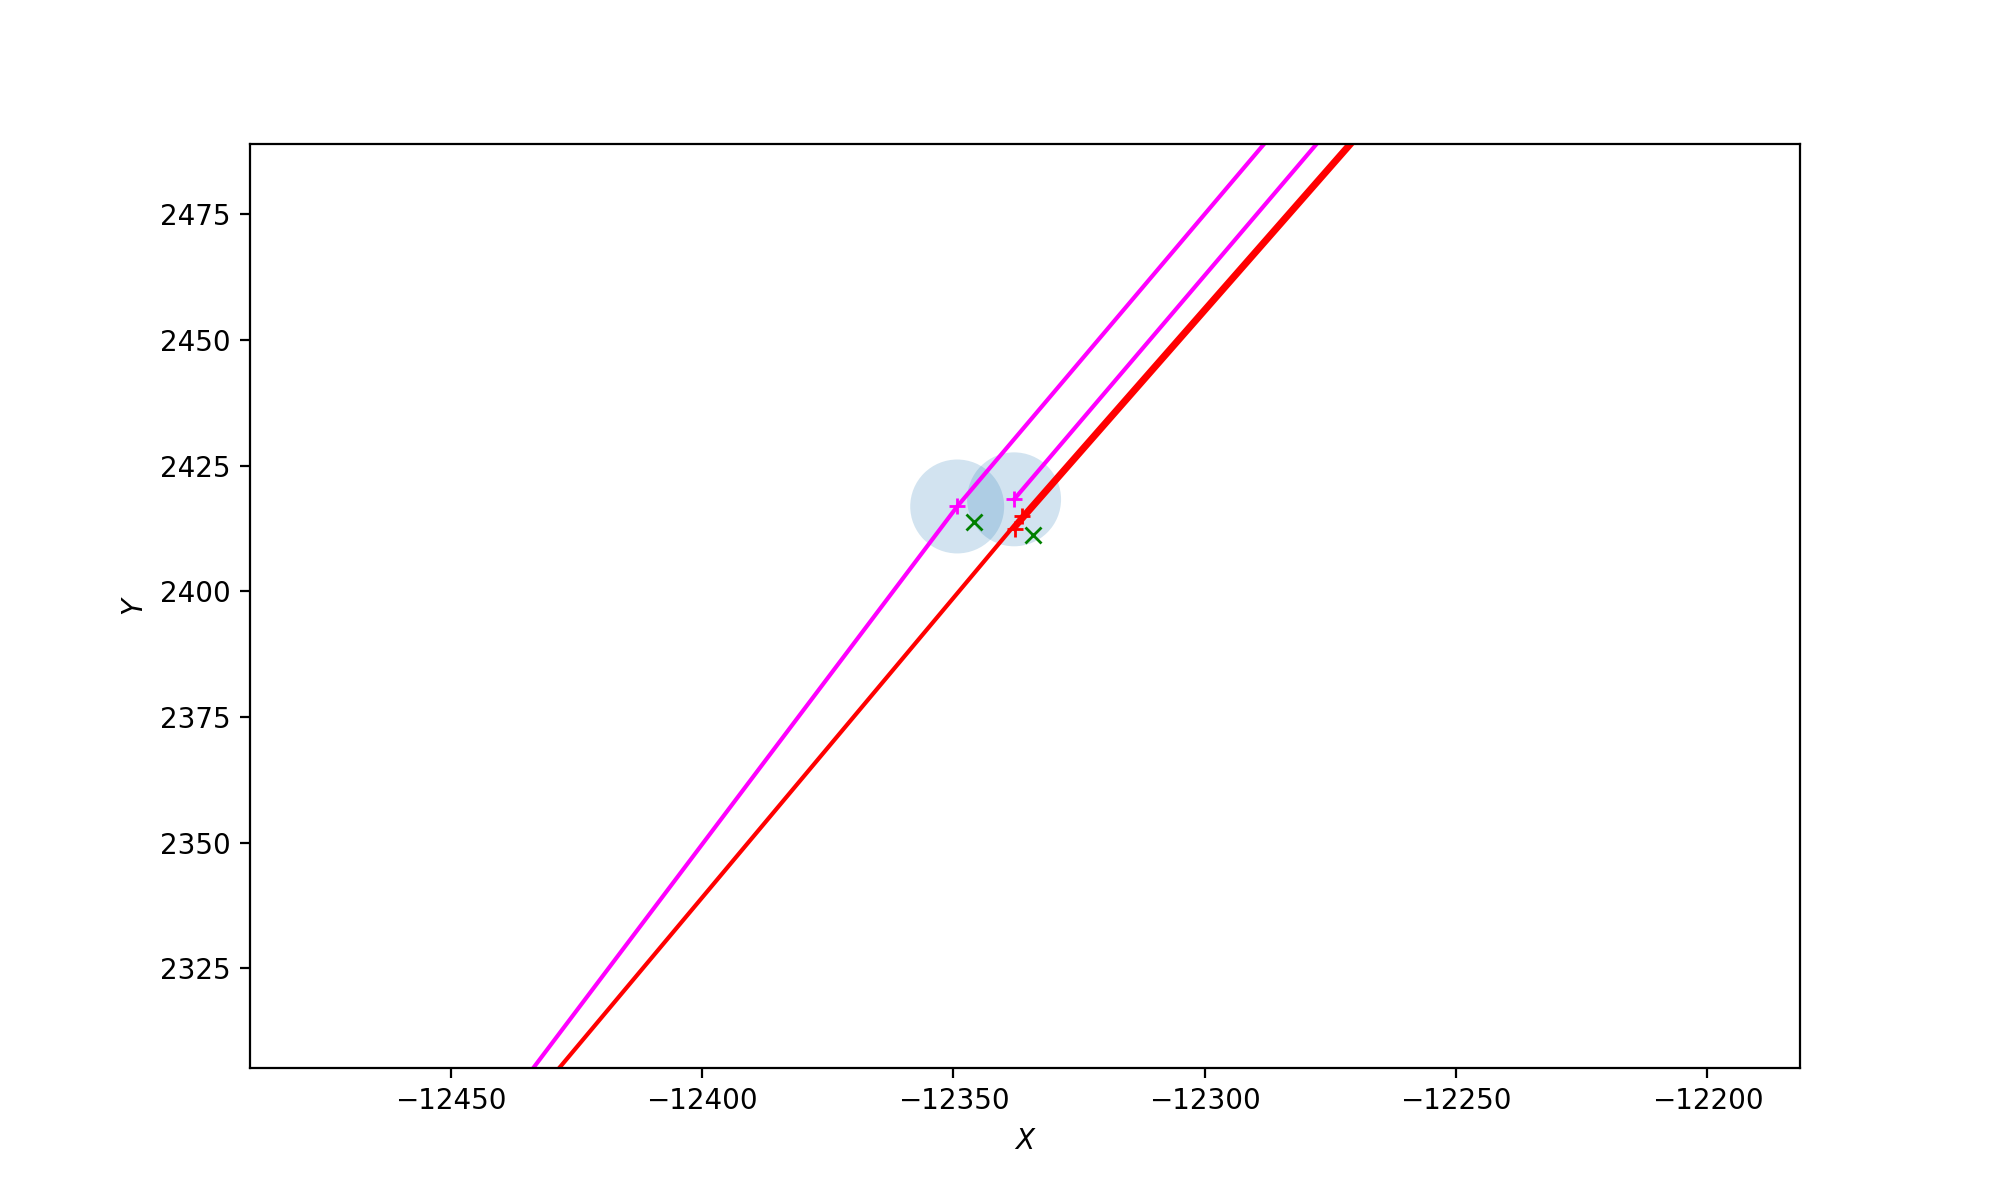

In [17]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("$X$")
ax.set_ylabel("$Y$")
ax.axis('equal')

from matplotlib.patches import Ellipse

HH = np.array([[ 1.,  0.,  0.,  0., 0., 0.],
               [ 0.,  1.,  0.,  0., 0., 0.]])
xxx=[]
yyy=[]
for state in track:
    m = HH@state.state_vector
    xxx.append(m[0])
    yyy.append(m[1])
    
# Some re-plots
line1, = ax.plot(xx,yy,color="blue") 
line2, = ax.plot(all_xy[:][0], all_xy[:][1], color="red", marker="+")
line3, = ax.plot(sens_xy[:][0], sens_xy[:][1],'x', color="green")
line4, = ax.plot(xxx,yyy, color='magenta', marker="+")

for state in track:
    w, v = np.linalg.eig(HH@state.covar@HH.T)
    max_ind = np.argmax(v[0, :])
    orient = np.arctan2(v[max_ind, 1], v[max_ind, 0])
    ellipse = Ellipse(xy=state.state_vector[(0,1), 0],
                      width=np.sqrt(w[0])*2, height=np.sqrt(w[1])*2,
                      angle=np.rad2deg(orient),
                      alpha=0.2)
    ax.add_artist(ellipse)